# Task 1 - Image Colorization as a Regression Problem

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms as transforms

!pip install torchmetrics
from torchmetrics import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics import PeakSignalNoiseRatio as PSNR
!pip install lpips
import lpips

from skimage import color
import torchvision.utils

### Generic Parameter Settings

In [2]:
val_size = 5000
use_gpu = True

### Loading CIFAR Data

In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split

# converts the PIL image to a pytorch tensor containing an LAB image
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))
    
img_transform = transforms.Compose([
    transforms.Lambda(import_image)
])

dataset = CIFAR10('./data/CIFAR10', transform=img_transform, target_transform=None, download=True)
train_dataset, val_dataset = random_split(dataset, [len(dataset) - val_size, val_size])
test_dataset = CIFAR10('./data/CIFAR10', train=False, transform=img_transform, target_transform=None, download=True)


100%|██████████| 170498071/170498071 [00:03<00:00, 48198735.95it/s]


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


### Models

In [4]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [ ]:
class ColorizationDenseNet(nn.Module):
    def __init__(self, input_size=128):
        super(ColorizationDenseNet, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128

        # First half: DenseNet
        densenet = models.densenet121(pretrained=True)
        # Change first conv layer to accept single-channel (grayscale) input
        densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Extract midlevel features from DenseNet-gray
        self.midlevel_densenet = nn.Sequential(*list(densenet.features.children())[0:6])
        
        # Second half: Upsampling
        self.upsample = nn.Sequential(
        nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=2)
    )

    def forward(self, input):

        # Pass input through ResNet-gray to extract features
        midlevel_features = self.midlevel_densenet(input)

        # Upsample to get colors
        output = self.upsample(midlevel_features)
        return output

In [25]:
class BaseColor(nn.Module):
	def __init__(self):
		super(BaseColor, self).__init__()

		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm


class ColorizationECCVNet(BaseColor):
  def __init__(self, norm_layer=nn.BatchNorm2d):
    super(ColorizationECCVNet, self).__init__()
    model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
    model1+=[nn.ReLU(True),]
    model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
    model1+=[nn.ReLU(True),]
    model1+=[norm_layer(64),]

    model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
    model2+=[nn.ReLU(True),]
    model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
    model2+=[nn.ReLU(True),]
    model2+=[norm_layer(128),]

    model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
    model3+=[nn.ReLU(True),]
    model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
    model3+=[nn.ReLU(True),]
    model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
    model3+=[nn.ReLU(True),]
    model3+=[norm_layer(256),]

    model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
    model4+=[nn.ReLU(True),]
    model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
    model4+=[nn.ReLU(True),]
    model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
    model4+=[nn.ReLU(True),]
    model4+=[norm_layer(512),]

    model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
    model5+=[nn.ReLU(True),]
    model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
    model5+=[nn.ReLU(True),]
    model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
    model5+=[nn.ReLU(True),]
    model5+=[norm_layer(512),]

    model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
    model6+=[nn.ReLU(True),]
    model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
    model6+=[nn.ReLU(True),]
    model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
    model6+=[nn.ReLU(True),]
    model6+=[norm_layer(512),]

    model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
    model7+=[nn.ReLU(True),]
    model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
    model7+=[nn.ReLU(True),]
    model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
    model7+=[nn.ReLU(True),]
    model7+=[norm_layer(512),]

    model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
    model8+=[nn.ReLU(True),]
    model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
    model8+=[nn.ReLU(True),]
    model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
    model8+=[nn.ReLU(True),]

    model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

    self.model1 = nn.Sequential(*model1)
    self.model2 = nn.Sequential(*model2)
    self.model3 = nn.Sequential(*model3)
    self.model4 = nn.Sequential(*model4)
    self.model5 = nn.Sequential(*model5)
    self.model6 = nn.Sequential(*model6)
    self.model7 = nn.Sequential(*model7)
    self.model8 = nn.Sequential(*model8)

    self.softmax = nn.Softmax(dim=1)
    self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
    self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')

  def forward(self, input_l):
      conv1_2 = self.model1(self.normalize_l(input_l))
      conv2_2 = self.model2(conv1_2)
      conv3_3 = self.model3(conv2_2)
      conv4_3 = self.model4(conv3_3)
      conv5_3 = self.model5(conv4_3)
      conv6_3 = self.model6(conv5_3)
      conv7_3 = self.model7(conv6_3)
      conv8_3 = self.model8(conv7_3)
      out_reg = self.model_out(self.softmax(conv8_3))

      return self.unnormalize_ab(self.upsample4(out_reg))

### Training

In [6]:
def epoch_loop(dataloader, model, loss_fn, device, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
    

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    num_batches = 0
    ssim = SSIM().to(device)
    psnr = PSNR().to(device)

    train_loss_avg = [0]
    train_ssim_avg = [0]
    train_psnr_avg = [0]

    with torch.set_grad_enabled(is_train):
      for lab_batch, _ in dataloader:

        lab_batch = lab_batch.to(device)
        
        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = model(lab_batch[:, 0:1, :, :])
        
        loss = loss_fn(predicted_ab_batch, lab_batch[:, 1:3, :, :])
        
        if is_train:
          # backpropagation
          optimizer.zero_grad()
          loss.backward()
          # one step of the optmizer (using the gradients from backpropagation)
          optimizer.step()
        
        # metrics
        train_loss_avg[-1] += loss.item()
        train_ssim_avg[-1] += ssim(predicted_ab_batch, lab_batch[:, 1:3, :, :]).item()
        train_psnr_avg[-1] += psnr(predicted_ab_batch, lab_batch[:, 1:3, :, :]).item()

        num_batches += 1

    train_loss_avg[-1] /= num_batches
    train_ssim_avg[-1] /= num_batches
    train_psnr_avg[-1] /= num_batches

    return train_loss_avg[-1], train_ssim_avg[-1], train_psnr_avg[-1]

In [7]:
def train_validate(model, loss_fn, num_epochs, optimizer, device, train_dataloader, val_dataloader, model_name):
    best_val_loss = np.inf
    train_history = {'loss': [], 'ssim': [], 'psnr' : []}
    val_history = {'loss': [], 'ssim': [], 'psnr' : []}

    print("Start training...")
    for epoch in range(num_epochs):
      train_loss, train_ssim, train_psnr = epoch_loop(train_dataloader, model, loss_fn, device, optimizer, True)
      print('Train: Epoch [%d / %d] Loss: %f  SSIM: %f PSNR: %f' % (epoch+1, num_epochs, train_loss, train_ssim, train_psnr))
      val_loss, val_ssim, val_psnr = epoch_loop(val_dataloader, model, loss_fn, device, optimizer, False)
      print('Validation: Epoch [%d / %d] Loss: %f  SSIM: %f PSNR: %f' % (epoch+1, num_epochs, val_loss, val_ssim, val_psnr))

      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}
        torch.save(save_dict, model_name)

      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}
      torch.save(save_dict, 'latest_model.pth')

      train_history["loss"].append(train_loss)
      train_history["ssim"].append(train_ssim)
      train_history["psnr"].append(train_psnr)

      val_history["loss"].append(val_loss)
      val_history["ssim"].append(val_ssim)
      val_history["psnr"].append(val_psnr)

    return train_history, val_history

In [8]:
def plotTrainingHistory(train_history, val_history):

    plt.figure(figsize=(10,10))

    plt.subplot(3, 1, 1)
    plt.title('Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(3, 1, 2)
    plt.title('Structural Similarity Index Measure (SSIM)')
    plt.xlabel('Epochs')
    plt.plot(train_history['ssim'], label='train')
    plt.plot(val_history['ssim'], label='val')
    plt.legend(loc='best')

    plt.subplot(3, 1, 3)
    plt.title('Peak Signal-To-Noise Ratio (PSNR)')
    plt.xlabel('Epochs')
    plt.plot(train_history['psnr'], label='train')
    plt.plot(val_history['psnr'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

### Evaluate

In [9]:
def evaluate(model, device, loss_fn, optimizer, test_dataloader):
    test_loss, test_ssim, test_psnr = epoch_loop(test_dataloader, model, loss_fn, device, optimizer, False)
    print(f"\nTest Loss: {test_loss:.3f} \nTest SSIM: {test_ssim:.3f} \nTest PSNR: {test_psnr:.3f}")

### Show Results

In [10]:
def show_results(model, device):
    plt.ion()
    with torch.no_grad():

        # pick a random subset of images from the test set
        image_inds = np.random.choice(len(test_dataset), 25, replace=False)
        lab_batch = torch.stack([test_dataset[i][0] for i in image_inds])
        lab_batch = lab_batch.to(device)

        # predict colors (ab channels)
        predicted_ab_batch = model(lab_batch[:, 0:1, :, :])
        predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

        lab_batch = lab_batch.cpu()
        predicted_lab_batch = predicted_lab_batch.cpu()

        # convert to rgb
        rgb_batch = []
        gray_batch = []
        predicted_rgb_batch = []
        for i in range(lab_batch.size(0)):
            rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
            rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
            gray_img = np.transpose(lab_batch[i, 0:1, :, :].numpy().astype('float64'), (1, 2, 0))
            gray_batch.append(torch.FloatTensor(np.transpose(gray_img / np.max(gray_img), (2, 0, 1))))
            predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
            predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

        # plot images
        fig, ax = plt.subplots(figsize=(30, 30), nrows=1, ncols=3)
        ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(gray_batch), nrow=5).numpy(), (1, 2, 0)), cmap='gray')
        ax[0].title.set_text('grayscale')
        ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
        ax[1].title.set_text('re-colored')
        ax[2].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
        ax[2].title.set_text('original')
        plt.show()

## ResNet Model

### 1. Varying Loss Function

In [ ]:
num_epochs = 50
batch_size = 64
learning_rate = 1e-3

model = ColorizationNet()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Number of parameters: 954722


#### 1.1 MSE Loss

In [ ]:
criterion = F.mse_loss

In [ ]:
train_history, val_history = train_validate(model, criterion, num_epochs, optimizer, device, train_dataloader, val_dataloader, 'resnet_mse.pth')

Start training...
Train: Epoch [1 / 50] Loss: 161.184963  SSIM: 0.197599 PSNR: 20.910963
Validation: Epoch [1 / 50] Loss: 177.484957  SSIM: 0.193797 PSNR: 20.352947
Train: Epoch [2 / 50] Loss: 155.687237  SSIM: 0.207689 PSNR: 21.021622
Validation: Epoch [2 / 50] Loss: 154.270336  SSIM: 0.200369 PSNR: 20.981692
Train: Epoch [3 / 50] Loss: 152.166287  SSIM: 0.214381 PSNR: 21.168359
Validation: Epoch [3 / 50] Loss: 159.814505  SSIM: 0.190266 PSNR: 20.820998
Train: Epoch [4 / 50] Loss: 150.051089  SSIM: 0.218288 PSNR: 21.213599
Validation: Epoch [4 / 50] Loss: 171.214577  SSIM: 0.186579 PSNR: 20.604169
Train: Epoch [5 / 50] Loss: 147.940660  SSIM: 0.222103 PSNR: 21.290945
Validation: Epoch [5 / 50] Loss: 151.750065  SSIM: 0.212322 PSNR: 20.998904
Train: Epoch [6 / 50] Loss: 145.701628  SSIM: 0.225280 PSNR: 21.344058
Validation: Epoch [6 / 50] Loss: 156.750282  SSIM: 0.211394 PSNR: 20.992609
Train: Epoch [7 / 50] Loss: 143.452057  SSIM: 0.229329 PSNR: 21.406039
Validation: Epoch [7 / 50] Lo

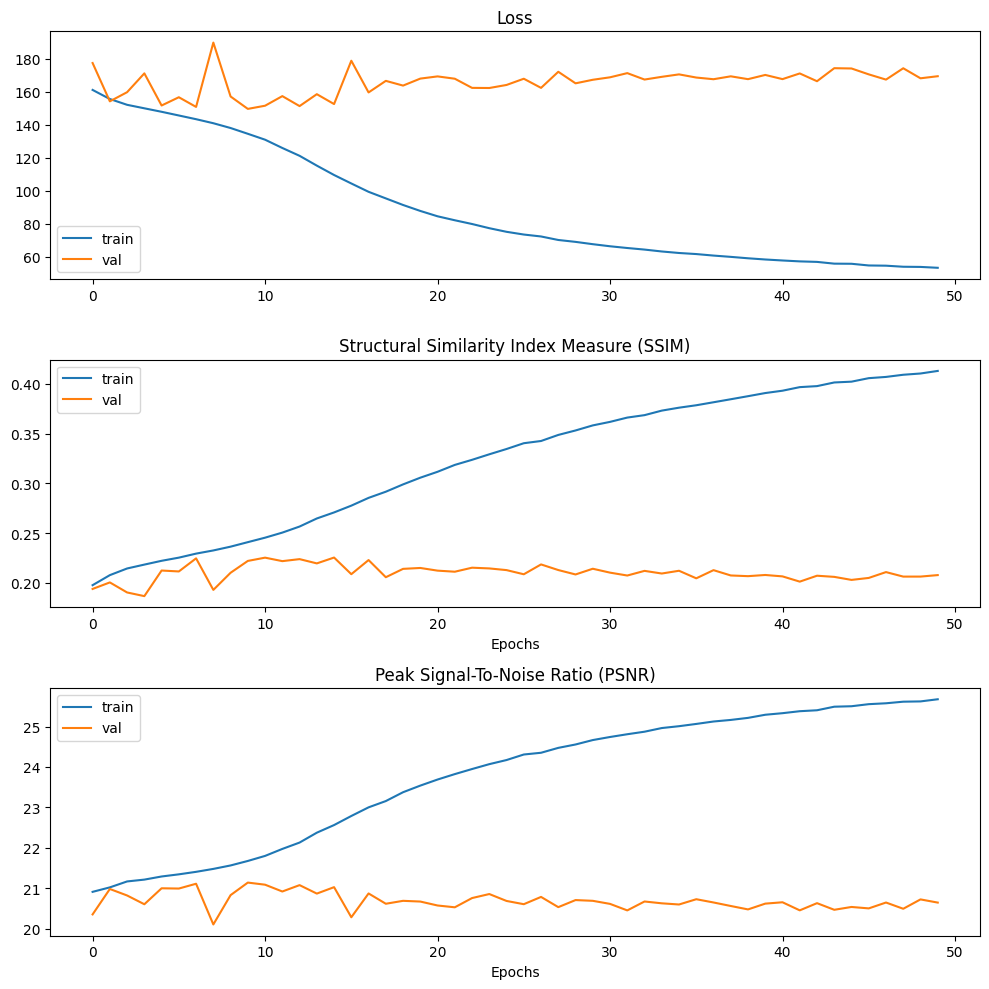

In [ ]:
plotTrainingHistory(train_history, val_history)

In [ ]:
loaded_model = model.to(device)
checkpoint = torch.load('resnet_mse.pth')
loaded_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
evaluate(loaded_model, device, criterion, optimizer, test_dataloader)


Test Loss: 147.256 
Test SSIM: 0.227 
Test PSNR: 21.212


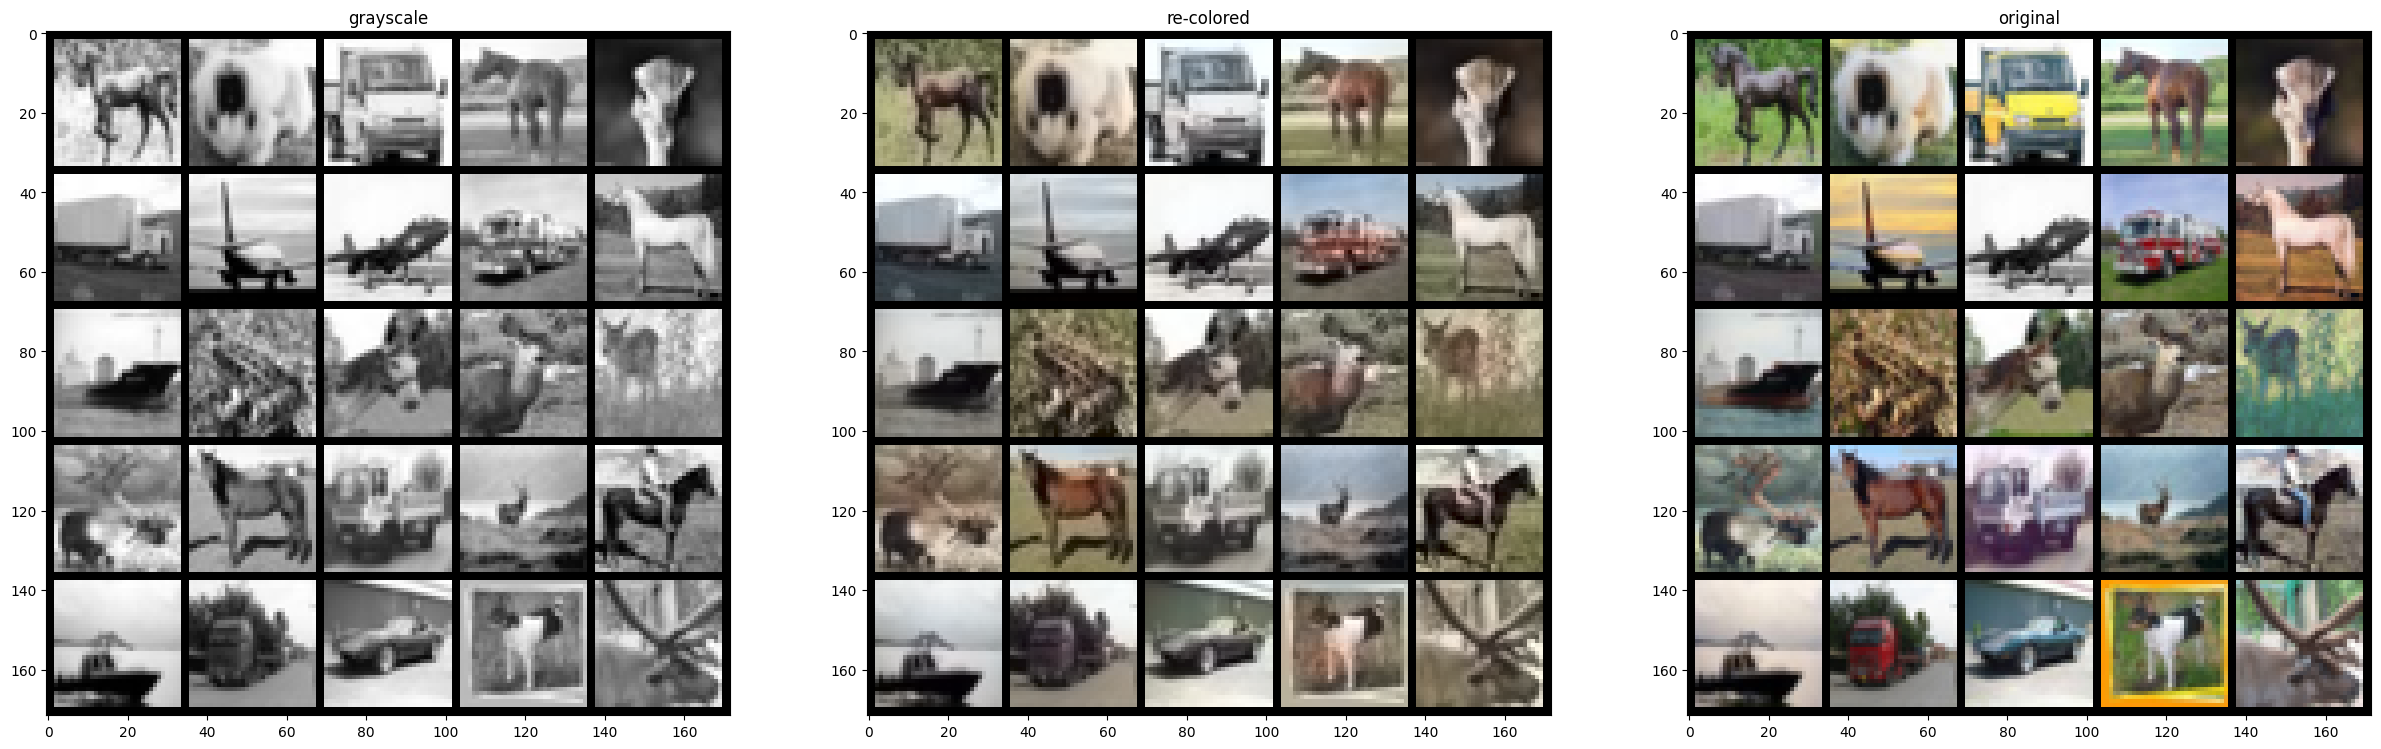

In [ ]:
show_results(loaded_model, device)

#### 1.2 LPIPS Loss

In [ ]:
criterion = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 232MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
def epoch_loop(dataloader, model, loss_fn, device, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
    

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    num_batches = 0
    ssim = SSIM().to(device)
    psnr = PSNR().to(device)

    train_loss_avg = [0]
    train_ssim_avg = [0]
    train_psnr_avg = [0]

    with torch.set_grad_enabled(is_train):
      for lab_batch, _ in dataloader:

        lab_batch = lab_batch.to(device)
        
        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = model(lab_batch[:, 0:1, :, :])
        predicted_ab_batch_3 = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)
        
        # adapated fo lpips
        loss = loss_fn(predicted_ab_batch_3, lab_batch).mean()
        
        if is_train:
          # backpropagation
          optimizer.zero_grad()
          loss.backward()
          # one step of the optmizer (using the gradients from backpropagation)
          optimizer.step()
        
        # metrics
        train_loss_avg[-1] += loss.item()
        train_ssim_avg[-1] += ssim(predicted_ab_batch, lab_batch[:, 1:3, :, :]).item()
        train_psnr_avg[-1] += psnr(predicted_ab_batch, lab_batch[:, 1:3, :, :]).item()

        num_batches += 1

    train_loss_avg[-1] /= num_batches
    train_ssim_avg[-1] /= num_batches
    train_psnr_avg[-1] /= num_batches

    return train_loss_avg[-1], train_ssim_avg[-1], train_psnr_avg[-1]

In [ ]:
train_history, val_history = train_validate(model, criterion, num_epochs, optimizer, device, train_dataloader, val_dataloader, 'resnet_lpips.pth')

Start training...
Train: Epoch [1 / 50] Loss: 0.103204  SSIM: 0.195422 PSNR: 20.761179
Validation: Epoch [1 / 50] Loss: 0.102903  SSIM: 0.195595 PSNR: 20.797459
Train: Epoch [2 / 50] Loss: 0.099014  SSIM: 0.201666 PSNR: 20.955168
Validation: Epoch [2 / 50] Loss: 0.101244  SSIM: 0.203652 PSNR: 20.947788
Train: Epoch [3 / 50] Loss: 0.097198  SSIM: 0.205644 PSNR: 21.015616
Validation: Epoch [3 / 50] Loss: 0.100544  SSIM: 0.197844 PSNR: 20.869302
Train: Epoch [4 / 50] Loss: 0.095798  SSIM: 0.211226 PSNR: 21.093767
Validation: Epoch [4 / 50] Loss: 0.098098  SSIM: 0.212329 PSNR: 20.958042
Train: Epoch [5 / 50] Loss: 0.094331  SSIM: 0.213270 PSNR: 21.145384
Validation: Epoch [5 / 50] Loss: 0.107491  SSIM: 0.184702 PSNR: 20.569812
Train: Epoch [6 / 50] Loss: 0.092950  SSIM: 0.218910 PSNR: 21.233705
Validation: Epoch [6 / 50] Loss: 0.095269  SSIM: 0.203601 PSNR: 21.110295
Train: Epoch [7 / 50] Loss: 0.091437  SSIM: 0.221503 PSNR: 21.295923
Validation: Epoch [7 / 50] Loss: 0.097953  SSIM: 0.2119

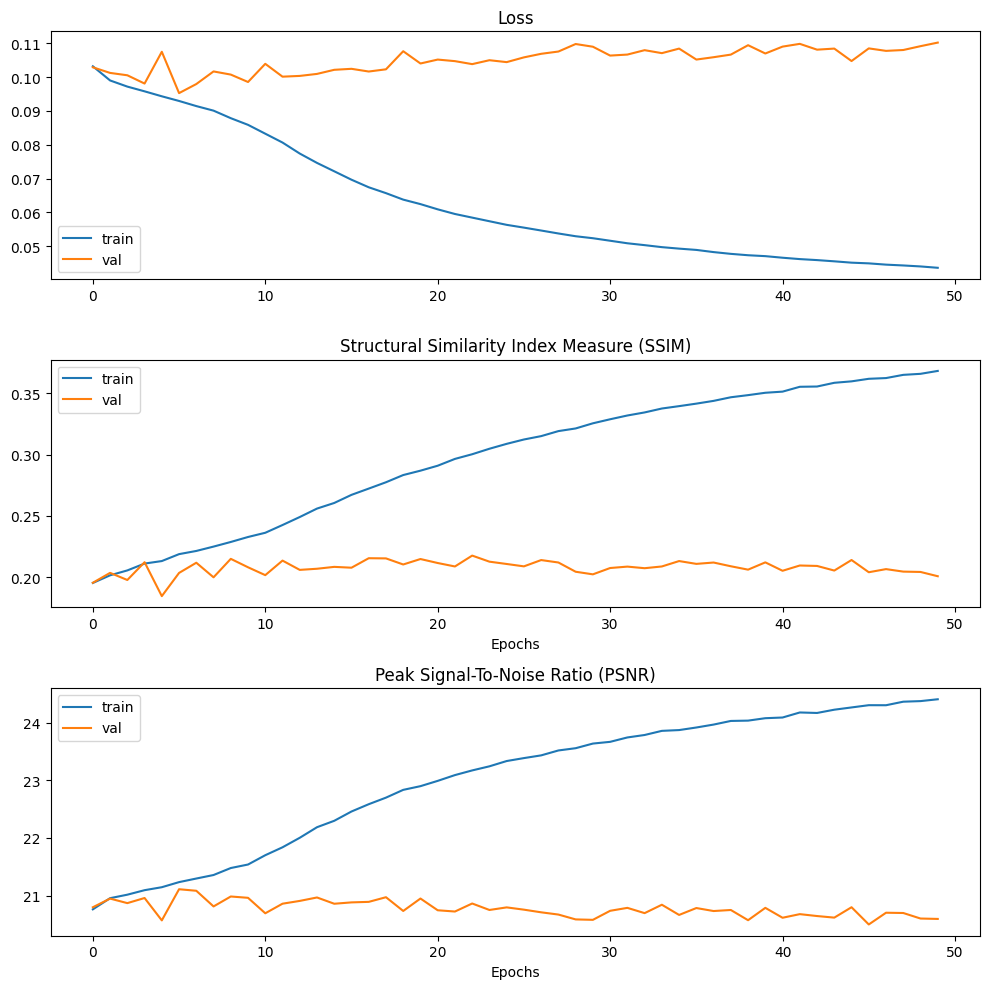

In [ ]:
plotTrainingHistory(train_history, val_history)

In [ ]:
loaded_model = model.to(device)
checkpoint = torch.load('resnet_lpips.pth')
loaded_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
evaluate(loaded_model, device, criterion, optimizer, test_dataloader)


Test Loss: 0.095 
Test SSIM: 0.207 
Test PSNR: 21.088


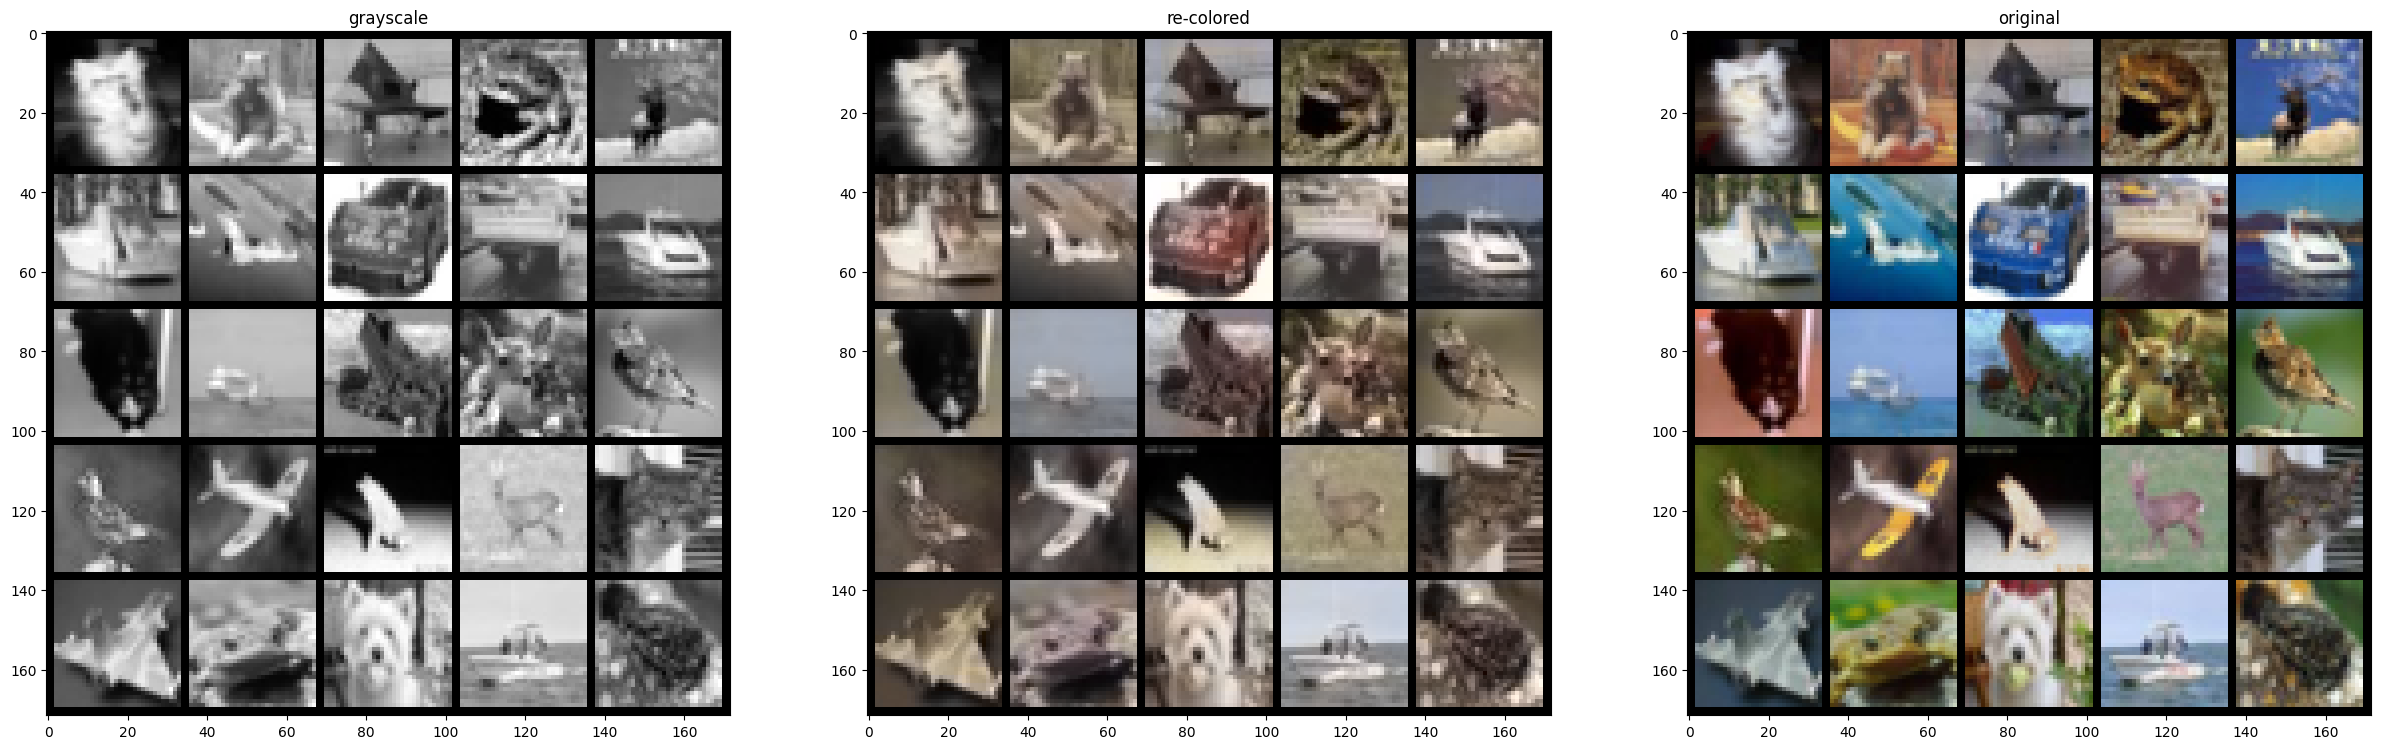

In [ ]:
show_results(loaded_model, device)

## ECCV Model

In [26]:
num_epochs = 50
batch_size = 64
learning_rate = 1e-3

model = ColorizationECCVNet()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

criterion = F.mse_loss

Number of parameters: 32236011


In [27]:
train_history, val_history = train_validate(model, criterion, num_epochs, optimizer, device, train_dataloader, val_dataloader, 'eccv_mse.pth')

Start training...
Train: Epoch [1 / 50] Loss: 174.531266  SSIM: 0.178837 PSNR: 20.513931
Validation: Epoch [1 / 50] Loss: 178.618310  SSIM: 0.176037 PSNR: 20.605759
Train: Epoch [2 / 50] Loss: 165.048754  SSIM: 0.189098 PSNR: 20.803397
Validation: Epoch [2 / 50] Loss: 170.697686  SSIM: 0.179011 PSNR: 20.850359
Train: Epoch [3 / 50] Loss: 160.270541  SSIM: 0.186002 PSNR: 20.904619
Validation: Epoch [3 / 50] Loss: 165.230555  SSIM: 0.170717 PSNR: 20.918003
Train: Epoch [4 / 50] Loss: 158.448231  SSIM: 0.187511 PSNR: 20.959939
Validation: Epoch [4 / 50] Loss: 166.349053  SSIM: 0.201866 PSNR: 20.923370
Train: Epoch [5 / 50] Loss: 155.948761  SSIM: 0.188110 PSNR: 21.012068
Validation: Epoch [5 / 50] Loss: 162.258123  SSIM: 0.193133 PSNR: 20.981859
Train: Epoch [6 / 50] Loss: 155.078491  SSIM: 0.189437 PSNR: 21.050316
Validation: Epoch [6 / 50] Loss: 158.593903  SSIM: 0.196136 PSNR: 21.124807
Train: Epoch [7 / 50] Loss: 153.552985  SSIM: 0.191587 PSNR: 21.115211
Validation: Epoch [7 / 50] Lo

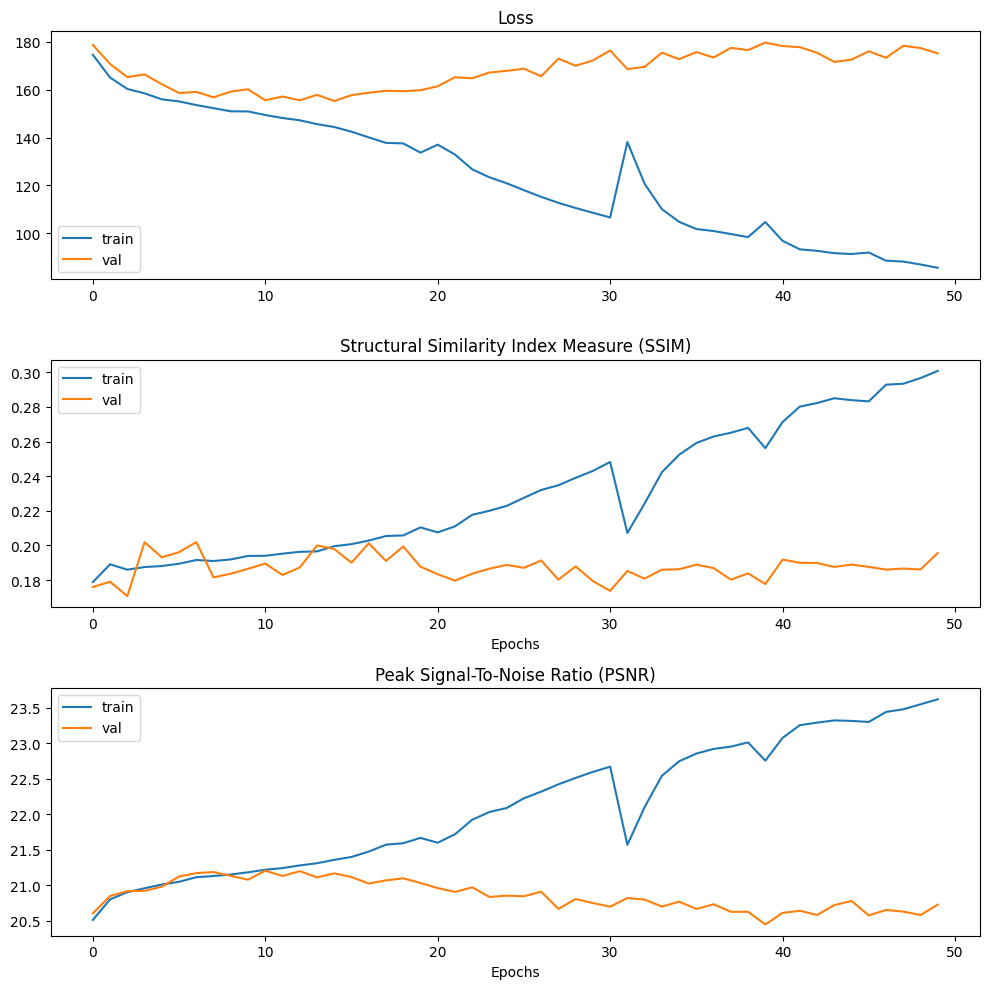

In [28]:
plotTrainingHistory(train_history, val_history)

In [29]:
loaded_model = model.to(device)
checkpoint = torch.load('eccv_mse.pth')
loaded_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [30]:
evaluate(loaded_model, device, criterion, optimizer, test_dataloader)


Test Loss: 150.343 
Test SSIM: 0.201 
Test PSNR: 21.130


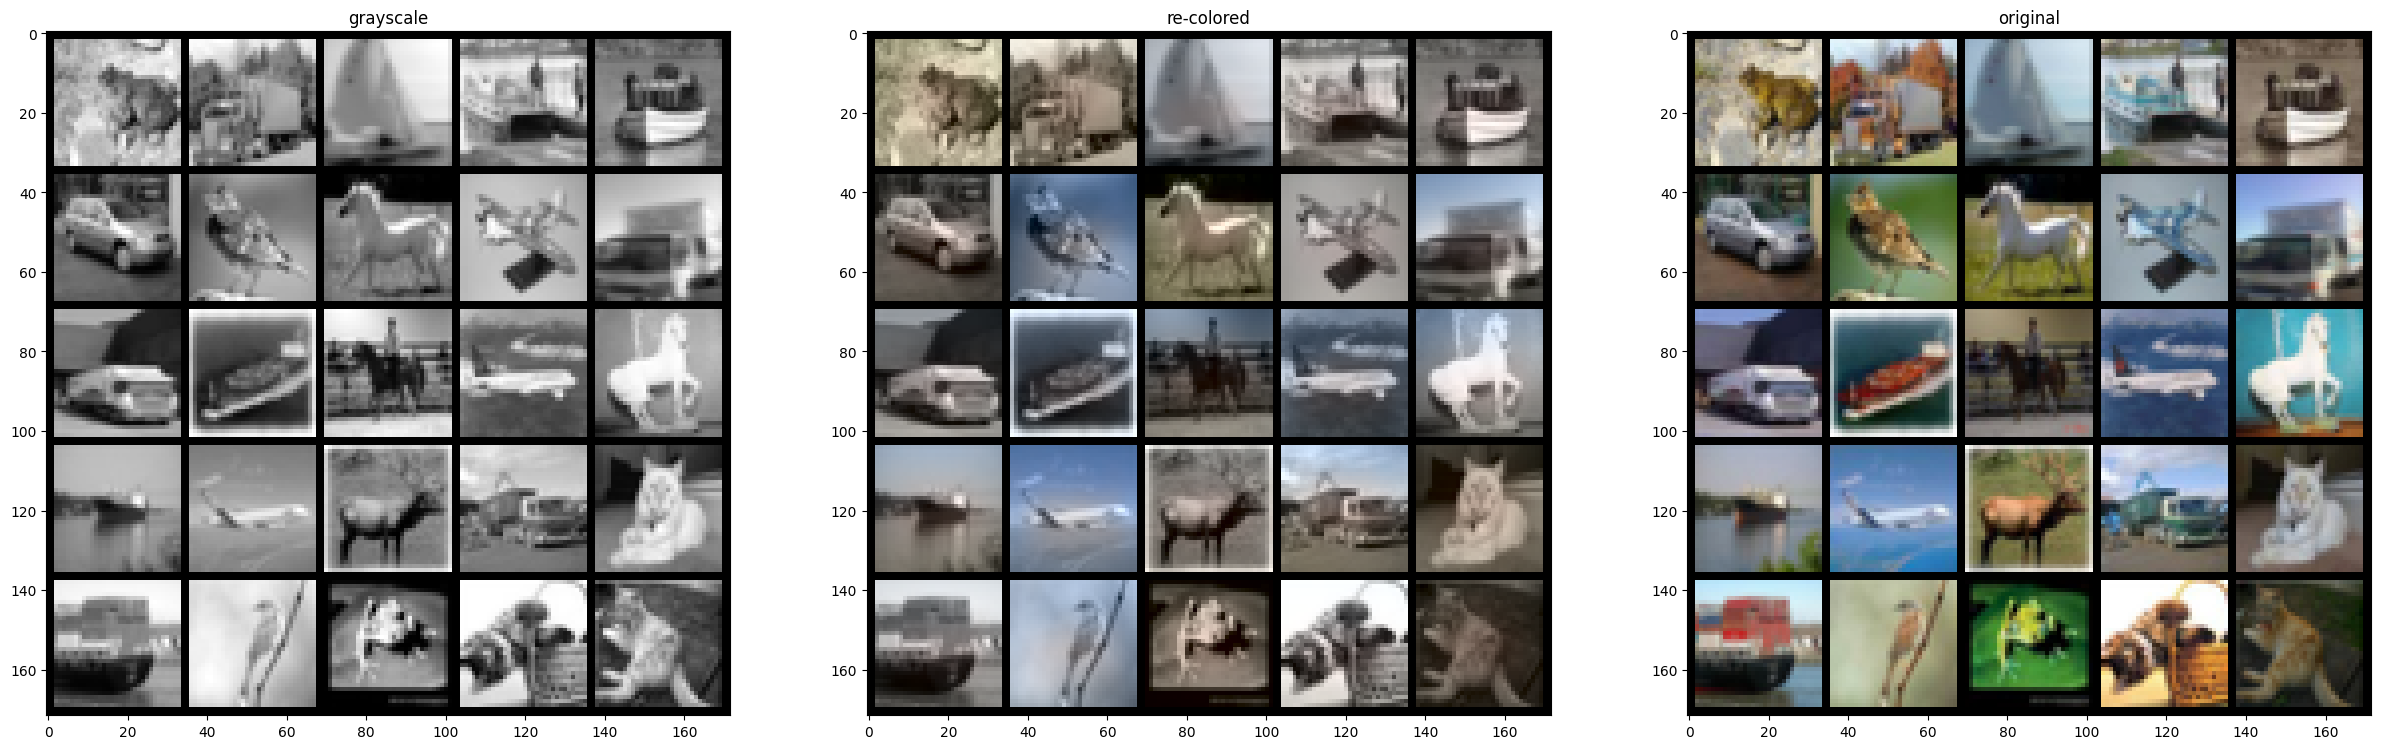

In [33]:
show_results(loaded_model, device)

## DenseNet Model

In [109]:
num_epochs = 50
batch_size = 64
learning_rate = 1e-3

model = ColorizationDenseNet()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Number of parameters: 649506


In [56]:
criterion = F.mse_loss

In [110]:
train_history, val_history = train_validate(model, criterion, num_epochs, optimizer, device, train_dataloader, val_dataloader, 'densenet_mse.pth')

Start training...
Train: Epoch [1 / 50] Loss: 160.291858  SSIM: 0.199924 PSNR: 20.918208
Validation: Epoch [1 / 50] Loss: 167.534117  SSIM: 0.190522 PSNR: 20.670340
Train: Epoch [2 / 50] Loss: 153.097610  SSIM: 0.212229 PSNR: 21.126175
Validation: Epoch [2 / 50] Loss: 161.325853  SSIM: 0.210858 PSNR: 20.915191
Train: Epoch [3 / 50] Loss: 150.055714  SSIM: 0.216985 PSNR: 21.214672
Validation: Epoch [3 / 50] Loss: 152.914849  SSIM: 0.218984 PSNR: 21.052989
Train: Epoch [4 / 50] Loss: 147.926300  SSIM: 0.221990 PSNR: 21.289937
Validation: Epoch [4 / 50] Loss: 178.363019  SSIM: 0.184453 PSNR: 20.344197
Train: Epoch [5 / 50] Loss: 145.492350  SSIM: 0.224573 PSNR: 21.358748
Validation: Epoch [5 / 50] Loss: 228.829055  SSIM: 0.179971 PSNR: 19.337657
Train: Epoch [6 / 50] Loss: 143.668833  SSIM: 0.227475 PSNR: 21.416494
Validation: Epoch [6 / 50] Loss: 154.505123  SSIM: 0.212248 PSNR: 20.990145
Train: Epoch [7 / 50] Loss: 141.473222  SSIM: 0.230512 PSNR: 21.451688
Validation: Epoch [7 / 50] Lo

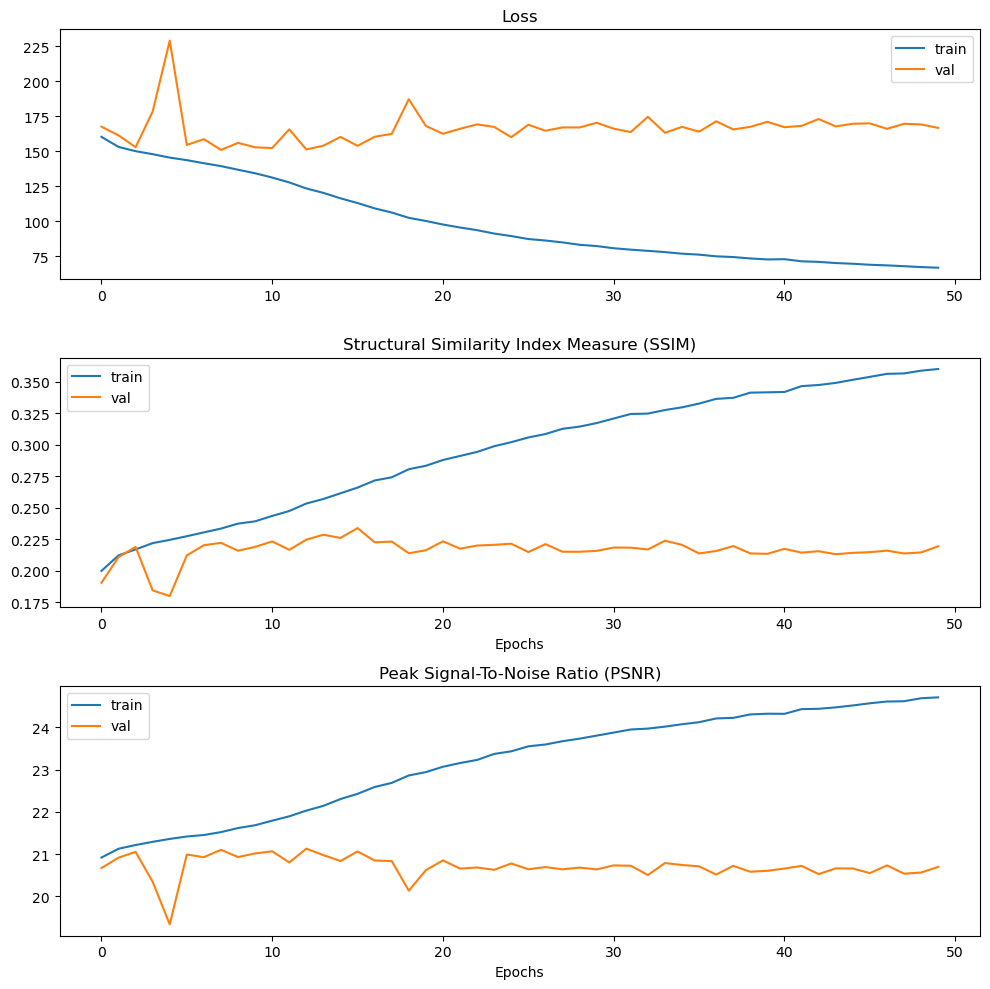

In [111]:
plotTrainingHistory(train_history, val_history)

In [112]:
loaded_model = model.to(device)
checkpoint = torch.load('densenet_mse.pth')
loaded_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [113]:
evaluate(loaded_model, device, criterion, optimizer, test_dataloader)


Test Loss: 149.831 
Test SSIM: 0.225 
Test PSNR: 21.190


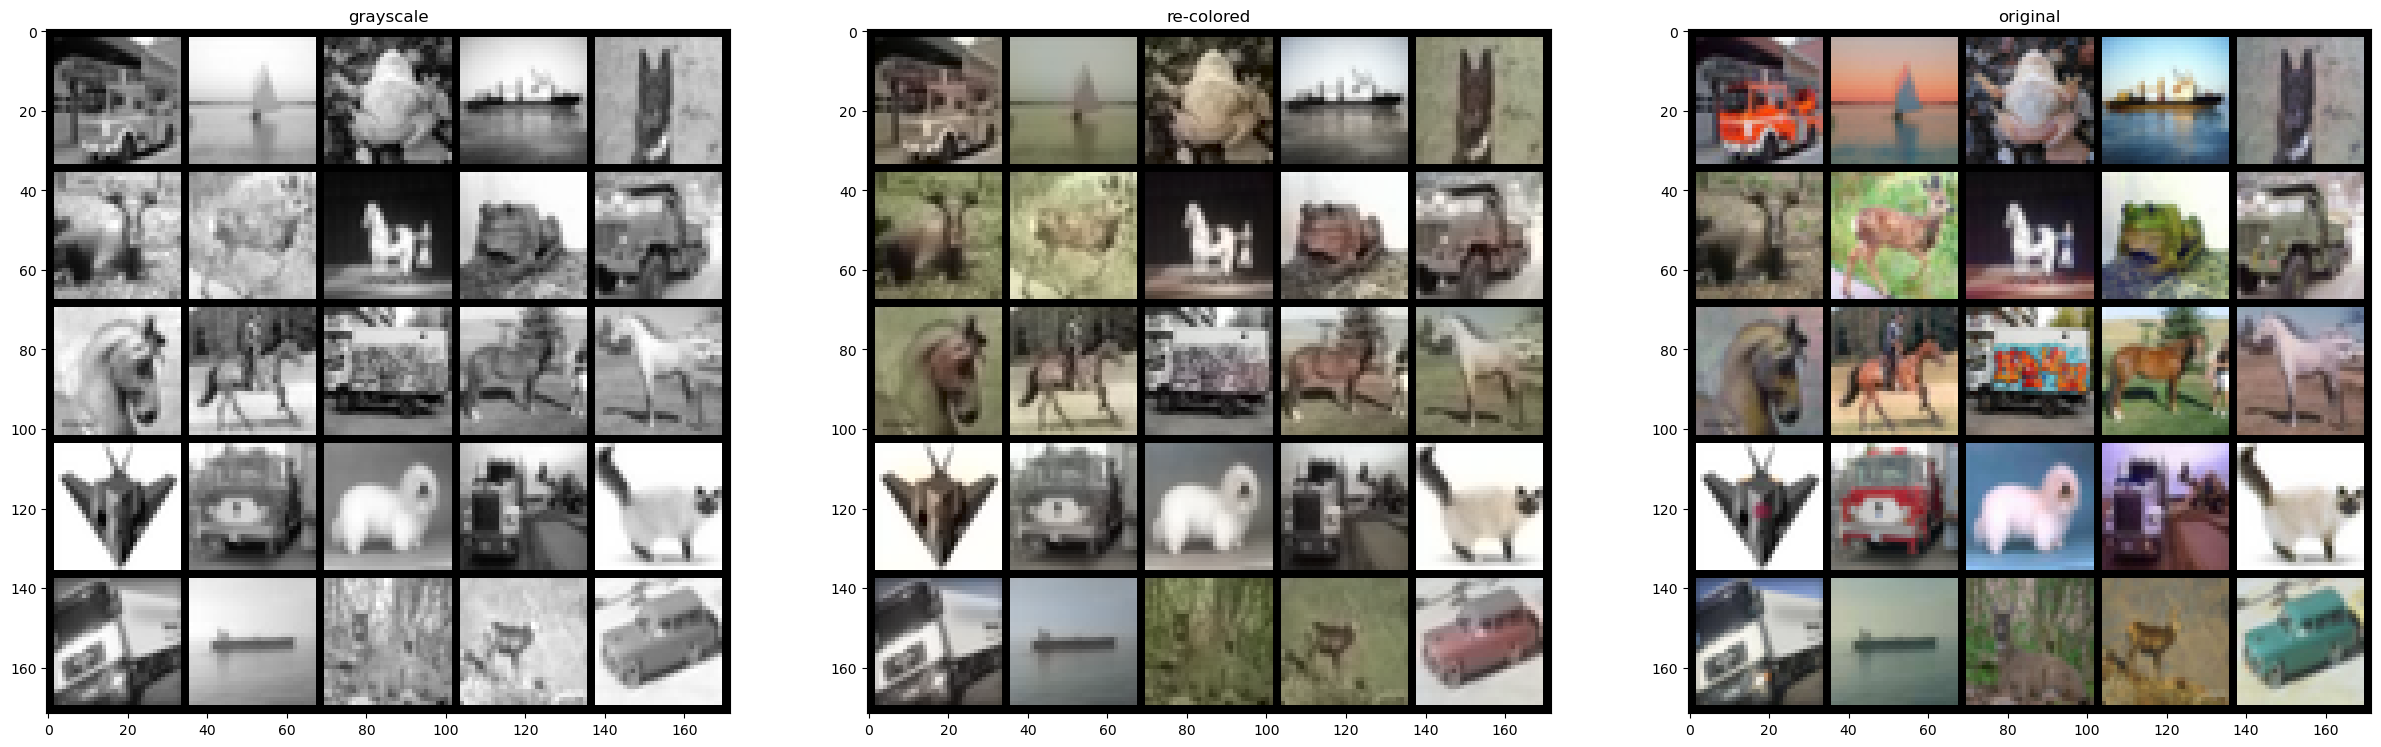

In [114]:
show_results(loaded_model, device)